# Egyszerű módszer GPS adatok feldolgozására

Ez a program az androidos "GPS Logger" app kimenetei közül a CSV-t dolgozza fel
Más programokkal is hasonló lenne a módszer, de a beolvasás módját igazítani kell a fájlformátumhoz

In [1]:
# Szokásos importálások
import numpy as np    # NumPy
import pandas as pd   # Pandas
%matplotlib inline    
import matplotlib.pyplot as plt # MatPlotLib

## Beolvasás

In [2]:
# Beolvasott fájl megadása
# A "GPS Logger" kimenetét feltételezi

input_file="./seta-1.txt" # ez egy séta
#input_file="./busz-1.txt" # buszozás 
#input_file="./vonat-2.txt"  # egy kis vonatozás
#input_file="./Kelenföld-Köki.txt"  # még egy kis vonatozás
#input_file="./vezetes-1.txt"  # egy Győrön belüli vezetés
#input_file="./Győr-Bodajk.txt"  # ez egy nagyobb autózás. De van egy kis gond az adatsorral.... 
data=pd.read_csv(input_file,sep=',')

In [3]:
# Ha nézegetni akajuk az adatokat:
#print(data.describe())   # összefoglaló
print(data.columns)       # oszlopnevek
#print(data.dtypes)       # típusok

Index(['type', 'date time', 'latitude', 'longitude', 'accuracy(m)',
       'altitude(m)', 'geoid_height(m)', 'speed(m/s)', 'bearing(deg)',
       'sat_used', 'sat_inview', 'name', 'desc'],
      dtype='object')


In [4]:
# stringben megadott idő konvertálása a 'date time' oszlop alapján
data["tdat"]=pd.to_datetime(data['date time'], format="%Y-%m-%d %H:%M:%S")

## Előfeldolgozás

In [5]:
# Nem érdekel az abszolút idő, csak a kezdetektől eltelt:
tdat_arr=data.tdat.to_numpy()
t_arr=(tdat_arr-tdat_arr[0])/np.timedelta64(1, 's')  
# most t_arr-ban az első mérési ponttól eltelt idő van
print(t_arr[:5], "...", t_arr[-5:])

[0. 1. 2. 3. 4.] ... [142. 143. 144. 145. 146.]


In [6]:
# Földrajzi koordináták konvertálása x-y-ra
# Ez egy közelítő megoldás! 
# Addig jó  közelítés, amíg a pálya mérete sokkal kisebb a Föld sugaránál
# x: nyugatról keletre
# y: délről északra

R_F=6378000.0 # a Föld sugara m-ben

long_arr=np.radians(data.longitude).to_numpy()  # hosszúsági adatok radiánba
lat_arr=np.radians(data.latitude).to_numpy()    # szélességi adatok radiánba

# Most jön maga a konverzió. Origó: 0. mérési pont
# Képzeletben az x és y tengelyeket rágörbítjük a szélességi és hosszúsági körökre.
x_arr=(long_arr-long_arr[0])*np.cos(lat_arr[0])*R_F
y_arr=(lat_arr-lat_arr[0])*R_F



### Egy kis debug

In [7]:
# Néhány általános adat nyomtatása
print("Mérési pontok száma   : %d"%(len(t_arr)))

delta_t=t_arr[-1]-t_arr[0]
print("Időtartam             : %.2f s"%(delta_t))

delta_x=x_arr[-1]-x_arr[0]
delta_y=y_arr[-1]-y_arr[0]
print("Elmozdulás-komponensek: %.2f m, %.2f m"%(delta_x, delta_y))

delta_r_abs=(delta_x**2+delta_y**2)**0.5   # Pitagorasz-tétel
print("Elmozdulás nagysága   : %.2f m"%(delta_r_abs))
print("Átlagsebesség-komponensek: %.2f m/s, %.2f m/s"%(delta_x/delta_t, delta_y/delta_t))
print("Átlagsebesség nagysága   : %.2f m/s"%(delta_r_abs/delta_t))


Mérési pontok száma   : 147
Időtartam             : 146.00 s
Elmozdulás-komponensek: -3.02 m, -0.67 m
Elmozdulás nagysága   : 3.09 m
Átlagsebesség-komponensek: -0.02 m/s, -0.00 m/s
Átlagsebesség nagysága   : 0.02 m/s


### Egyszerű megjelenítés

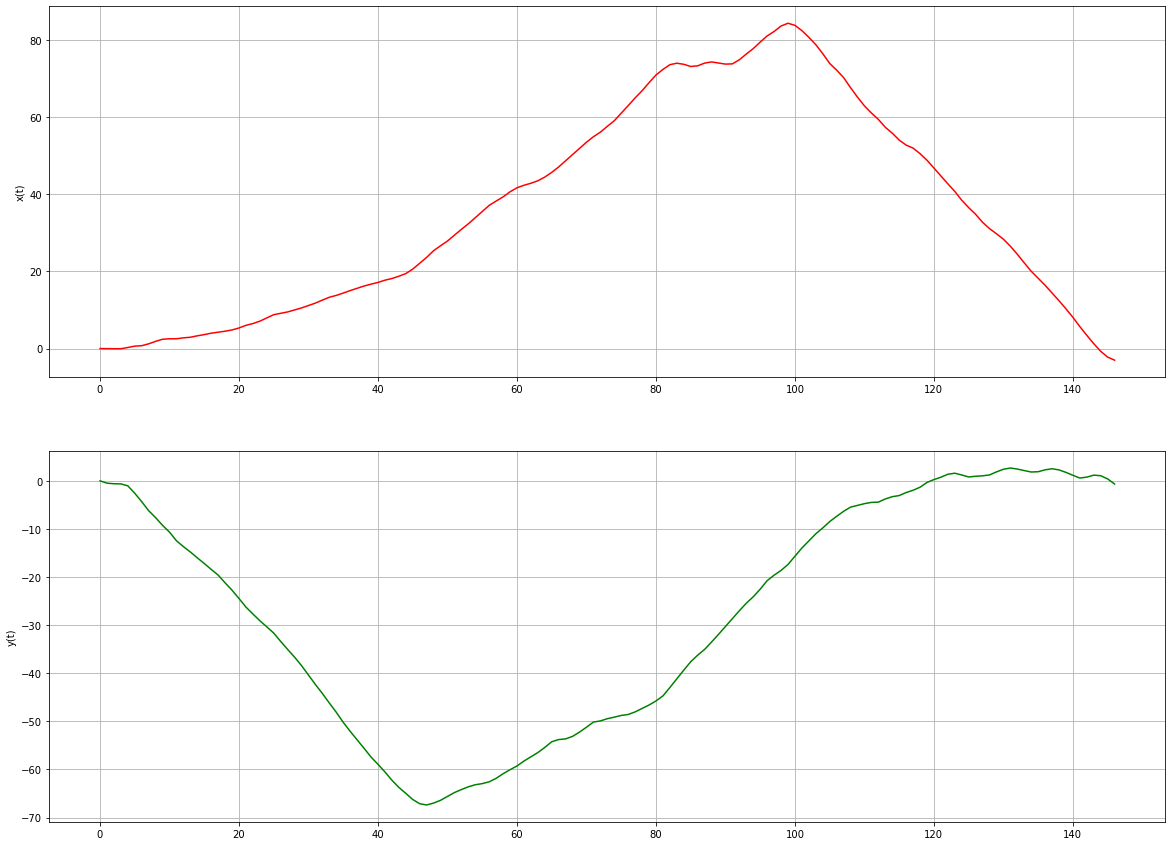

In [8]:
fig=plt.figure(figsize=(20,15))  # rajzméret
ax1=fig.add_subplot(211) # két rész-grafikon
ax2=fig.add_subplot(212)
ax1.set_ylabel("x(t)")
ax1.plot(t_arr, x_arr, color="red") # az elsőbe az x(t)
ax2.set_ylabel("y(t)")
ax2.plot(t_arr, y_arr, color="green") # a másodikba az y(t)
ax1.grid()
ax2.grid()

### Pályagörbe

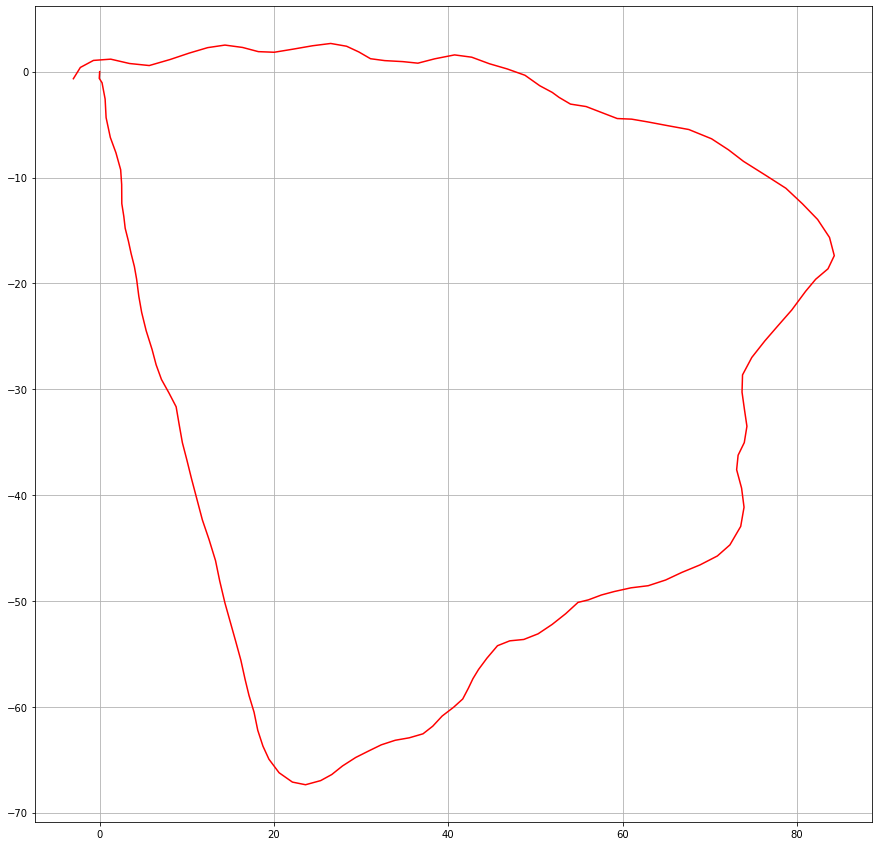

In [9]:
fig=plt.figure(figsize=(15,15))  # rajzméret
ax1=fig.add_subplot(111) 
ax1.plot(x_arr, y_arr, color="red") # x függvényében y
ax1.grid()

Ez így csak első közelítés! Nem látszik pl. az irány, vagy a tengelyeken nem azonos a lépték!

### Kinematikai számítások

In [10]:
# Ez egy igen egyszerű, numerikus közelítés.

def deriv(xx_tab, ff_tab):  # itt 'xx' az általános 'x' változót jelöli, nem az 'x' helykoordinátát!
    dff_dxx=np.zeros(xx_tab.shape, np.float64)
    dff_dxx[0]=(ff_tab[1]-ff_tab[0])/(xx_tab[1]-xx_tab[0]) # eleje
    dff_dxx[-1]=(ff_tab[-1]-ff_tab[-2])/(xx_tab[-1]-xx_tab[-2]) # vége
    dff_dxx[1:-1]=(ff_tab[2:]-ff_tab[0:-2])/(xx_tab[2:]-xx_tab[0:-2])  # közepe
    return(dff_dxx)

In [11]:
# sebesség-komponensek
vx_arr=deriv(t_arr, x_arr)
vy_arr=deriv(t_arr, y_arr)
# sebesség-nagyság:
vabs_arr=(vx_arr**2+vy_arr**2)**0.5

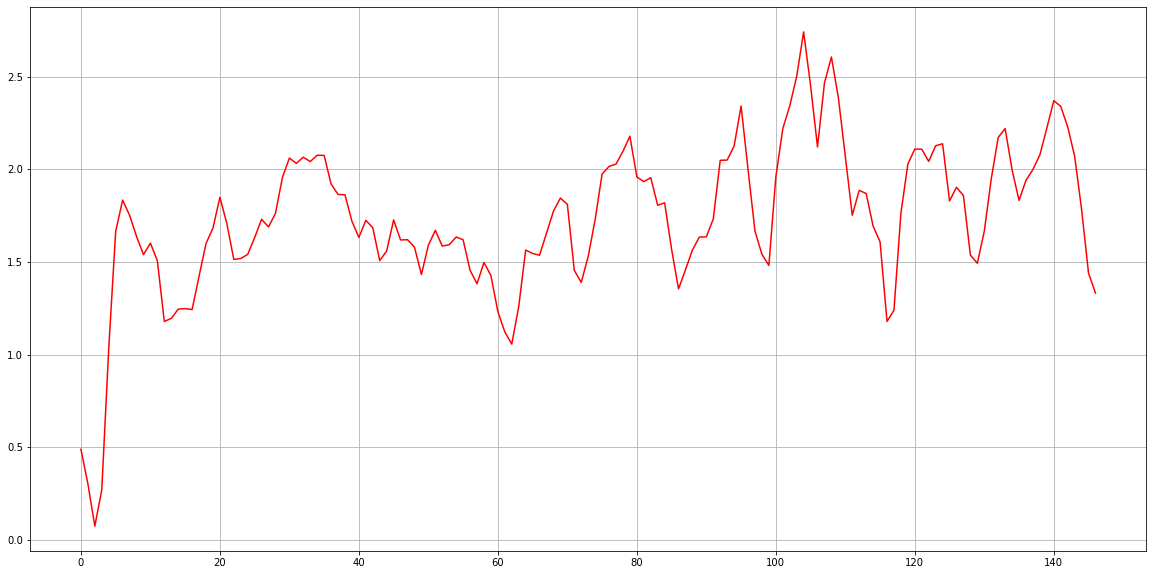

In [12]:
# hogyan alakult a sebesség nagysága?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, vabs_arr, color="red") 
ax1.grid()
# sok mérési adatsor esetén meglehetősen zajos lesz!

In [13]:
# út számítás
ut_arr=np.zeros(t_arr.shape, np.float64)
for i in range(1,len(ut_arr)):
    delta_x=x_arr[i]-x_arr[i-1]
    delta_y=y_arr[i]-y_arr[i-1]
    delta_ut=(delta_x**2+delta_y**2)**0.5
    ut_arr[i]=ut_arr[i-1]+ delta_ut

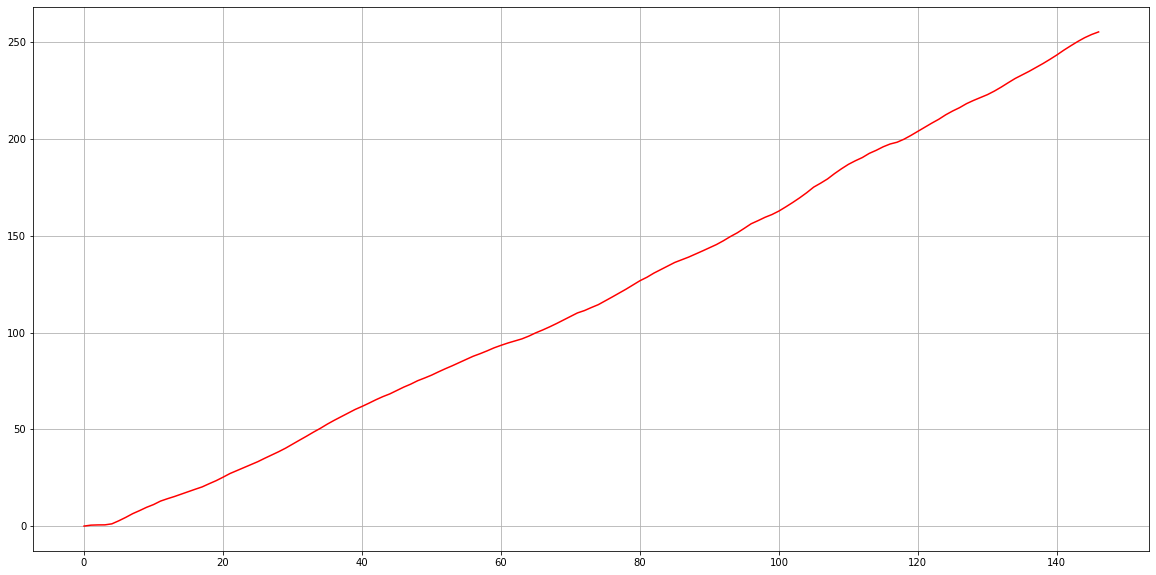

In [14]:
# hogyan alakult az eddig megtett út?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, ut_arr, color="red") 
ax1.grid()
# sokszor meglehetősen zajos lesz!

In [15]:
# teljes utat jellemző adatok:
print("Megtett út              : %.2f m"%(ut_arr[-1]))
print("Átlagos sebesség-nagyság: %0.2f m/s"%(ut_arr[-1]/t_arr[-1]))

Megtett út              : 255.35 m
Átlagos sebesség-nagyság: 1.75 m/s


In [16]:
# néhány általános adat: (ismétlés)
print("Mérési pontok száma   : %d"%(len(t_arr)))
delta_t=t_arr[-1]-t_arr[0]
print("Időtartam             : %.2f s"%(delta_t))
delta_x=x_arr[-1]-x_arr[0]
delta_y=y_arr[-1]-y_arr[0]
print("Elmozdulás-komponensek: %.2f m, %.2f m"%(delta_x, delta_y))
delta_r_abs=(delta_x**2+delta_y**2)**0.5   # Pitagorasz-tétel
print("Elmozdulás nagysága   : %.2f m"%(delta_r_abs))
print("Átlagsebesség-komponensek: %.2f m/s, %.2f m/s"%(delta_x/delta_t, delta_y/delta_t))
print("Átlagsebesség nagysága   : %.2f m/s"%(delta_r_abs/delta_t))


Mérési pontok száma   : 147
Időtartam             : 146.00 s
Elmozdulás-komponensek: -3.02 m, -0.67 m
Elmozdulás nagysága   : 3.09 m
Átlagsebesség-komponensek: -0.02 m/s, -0.00 m/s
Átlagsebesség nagysága   : 0.02 m/s


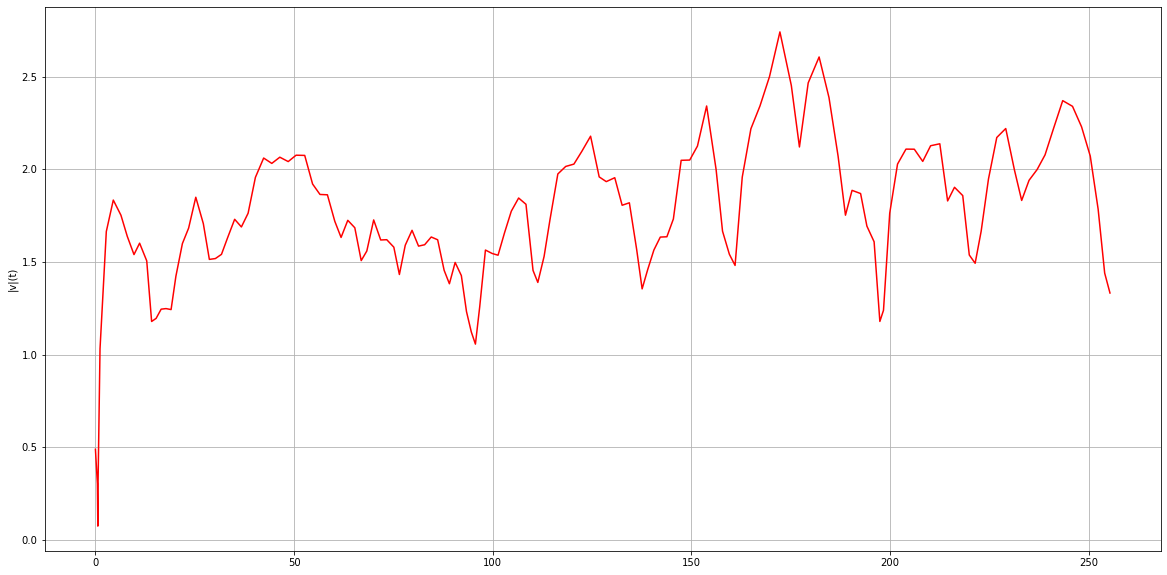

In [17]:
# Egy hasznos diagram: út függvényében a sebesség nagysága
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(ut_arr, vabs_arr, color="red") 
ax1.set_ylabel("|v|(t)")
ax1.grid()

### Kérdések

Miért olyan "rágott" a sebesség-diagram?

Miért nem érdemes gyorsulást számolni ezekből az adatokból?

# Az adatok simítása, szűrése

A mérési hiba miatt szükséges egy szűrő, simító lépés.

Ennek elmélete összetett. Itt csak egy sokszor hasznos receptet mutatunk be.

Savitzky-Golay szűrő: a csúszó átlagolás kiterjesztése.

Egy fix méretű 'ablak' mérési pontjaira illeszkedő 'N'-ed fokú polinomot határoz meg és ilyenekkel közelíti az adatsort.

Csak egyenletes mintavételezésű adatokra használható. (A GPS Logger többnyire azt ad.)

In [18]:
from scipy.signal import savgol_filter   # telepíteni kell a SciPy modult!

fokszam=5  # ennyied fokú csúszó polinom illesztés
ablak=21   # ennyi adatponttal (páratlan!)

xs_arr=savgol_filter(x_arr, ablak, fokszam)
ys_arr=savgol_filter(y_arr, ablak, fokszam)

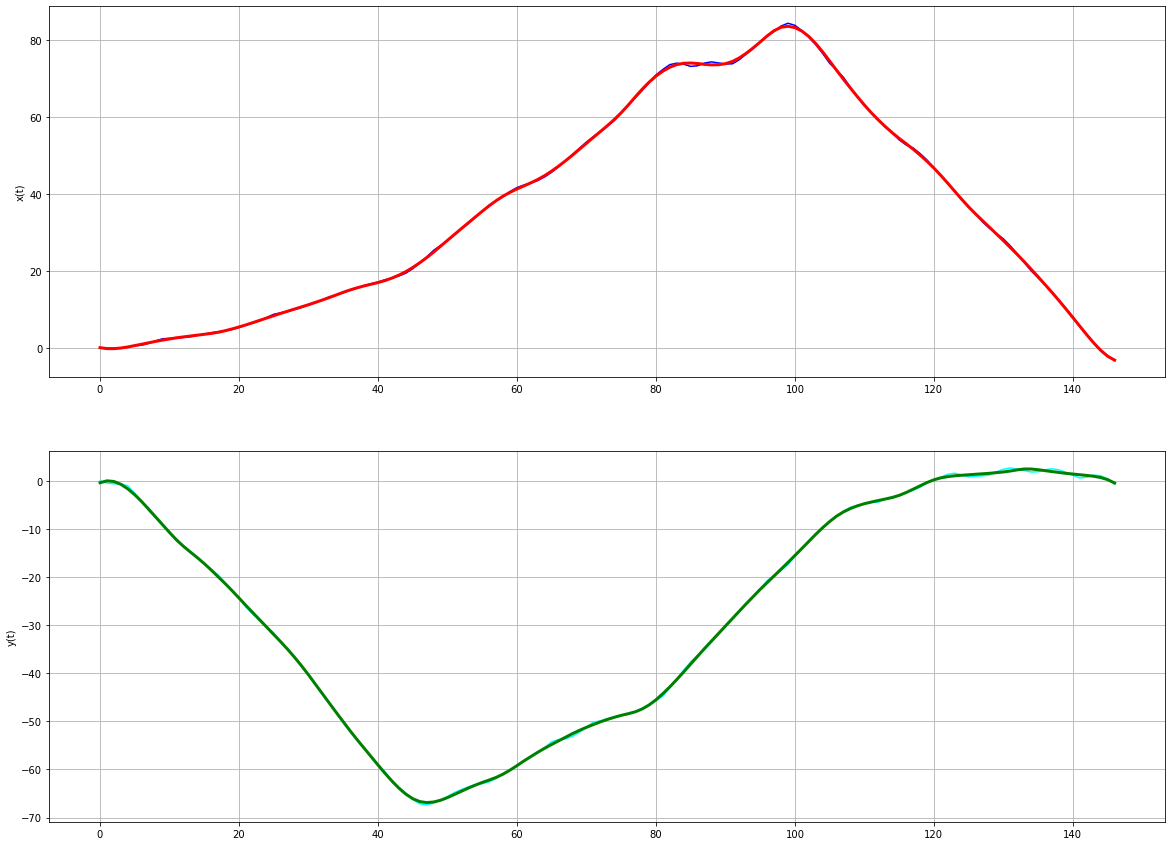

In [19]:
fig=plt.figure(figsize=(20,15))  # nagyobb rajzméret
ax1=fig.add_subplot(211) # két rész-grafikon
ax2=fig.add_subplot(212)
ax1.set_ylabel("x(t)")
ax1.plot(t_arr, x_arr, color="blue") # az elsőbe az x(t)
ax1.plot(t_arr, xs_arr, color="red", linewidth=3) 
ax2.set_ylabel("y(t)")
ax2.plot(t_arr, y_arr, color="cyan") # a másodikba az y(t)
ax2.plot(t_arr, ys_arr, color="green", linewidth=3) # a másodikba az y(t)
ax1.grid()
ax2.grid()

In [20]:
# nemigen látszik a különbség!

In [21]:
# sebesség-komponensek
vxs_arr=deriv(t_arr, xs_arr)
vys_arr=deriv(t_arr, ys_arr)
# sebesség-nagyság:
vsabs_arr=(vxs_arr**2+vys_arr**2)**0.5

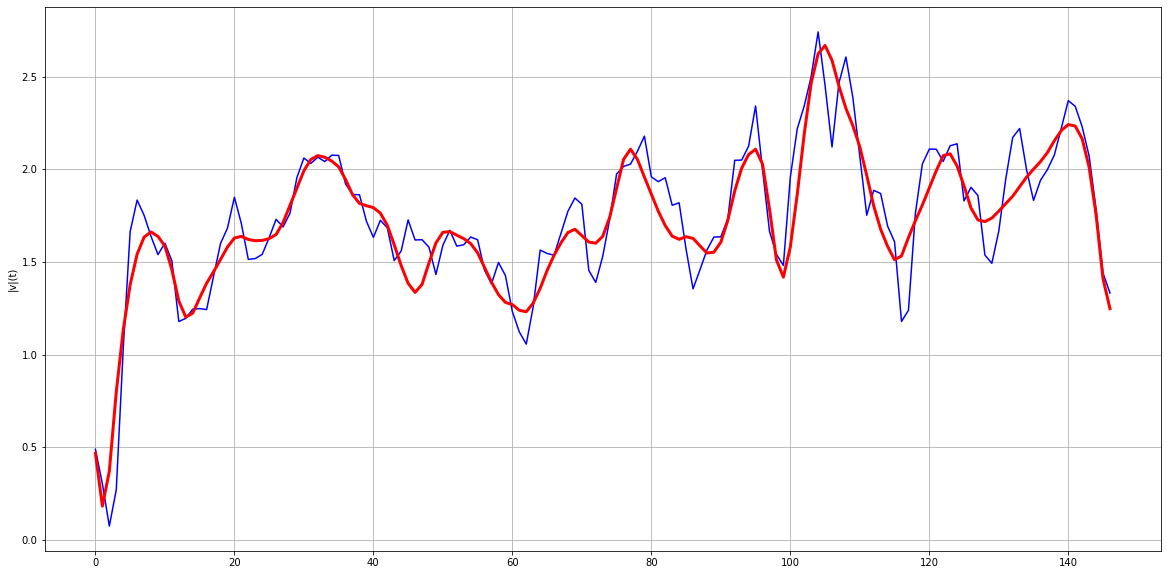

In [22]:
# hogyan alakult a sebesség nagysága?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, vabs_arr, color="blue") 
ax1.plot(t_arr, vsabs_arr, color="red", linewidth=3) 
ax1.set_ylabel("|v|(t)")
ax1.grid()
# ha szerencsénk van, már kevésbé zajos!

In [23]:
# ebből már van értelme gyorsulást számolni!

In [24]:
# gyorsulás-komponensek
axs_arr=deriv(t_arr, vxs_arr)
ays_arr=deriv(t_arr, vys_arr)
a_abs_arr=(axs_arr**2+ays_arr**2)**0.5

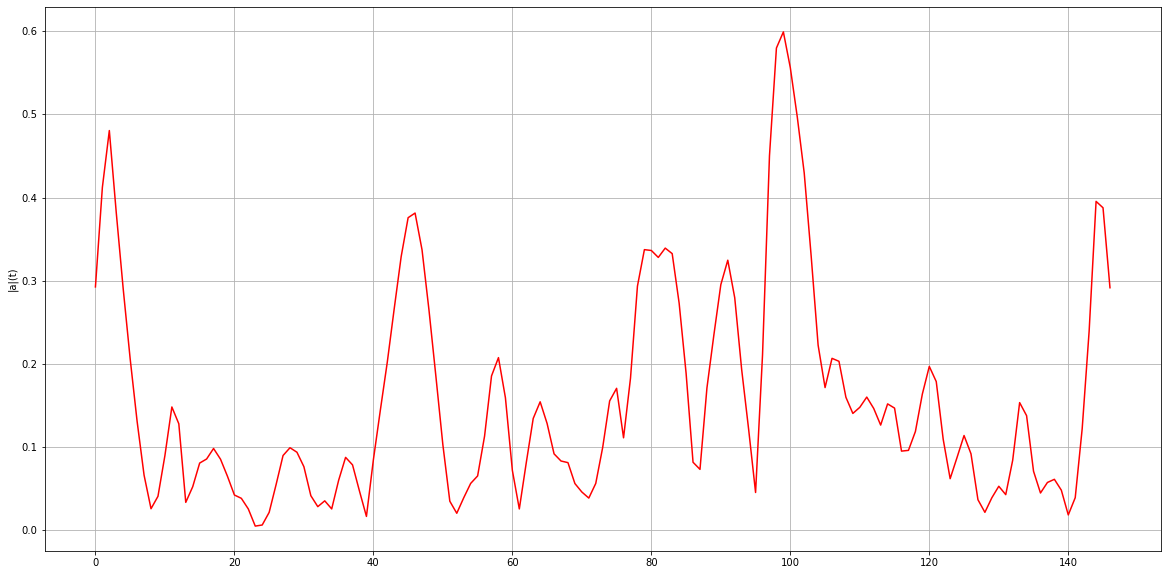

In [25]:
# hogyan alakult a gyorsulás nagysága?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, a_abs_arr, color="red") 
ax1.set_ylabel("|a|(t)")
ax1.grid()

In [26]:
# tanulság: ilyen adatsorból már nem igazán jó ötlet gyorsulást számolni...
# mi lehet a megoldás? ...

In [27]:
# lehet kicsit jobban:
# a Savitzky-Golay maga is tud deriválni, és az pontosabb:


In [28]:
vxs_arr=savgol_filter(x_arr, ablak, fokszam, deriv=1)  # deriv=1: 1. derivált
vys_arr=savgol_filter(y_arr, ablak, fokszam, deriv=1)
axs_arr=savgol_filter(x_arr, ablak, fokszam, deriv=2)  # deriv=2: 2. derivált
ays_arr=savgol_filter(y_arr, ablak, fokszam, deriv=2)
#
vsabs_arr=(vxs_arr**2+vys_arr**2)**0.5
as_abs_arr=(axs_arr**2+ays_arr**2)**0.5

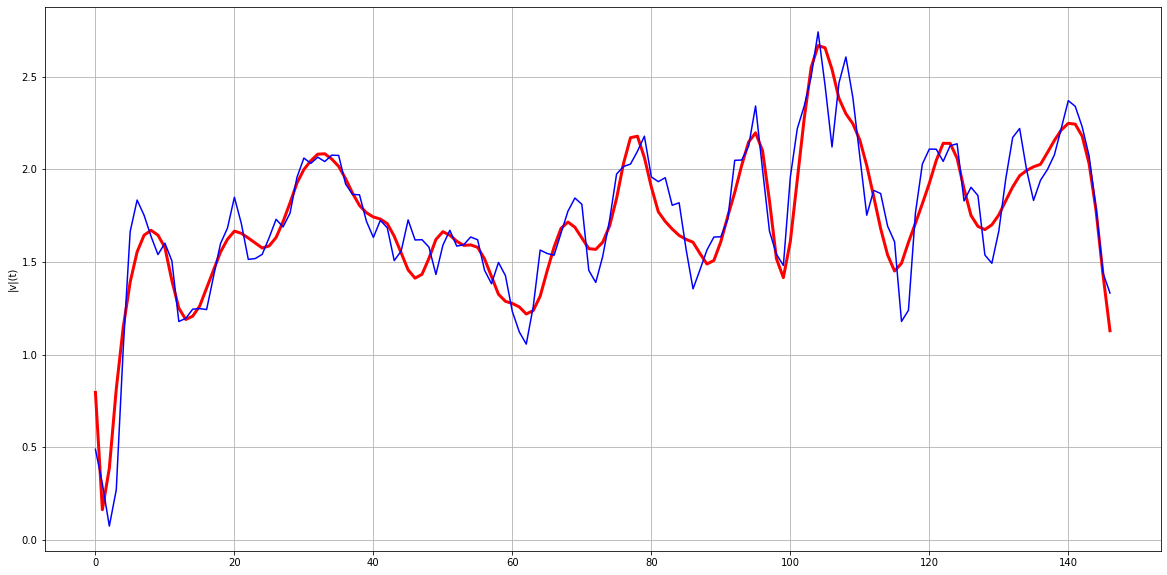

In [29]:
# hogyan alakult a sebesség nagysága?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, vsabs_arr, color="red", linewidth=3) 
ax1.plot(t_arr, vabs_arr, color="blue") 
ax1.set_ylabel("|v|(t)")
ax1.grid()
# ha szerencsénk van, már kevésbé zajos!

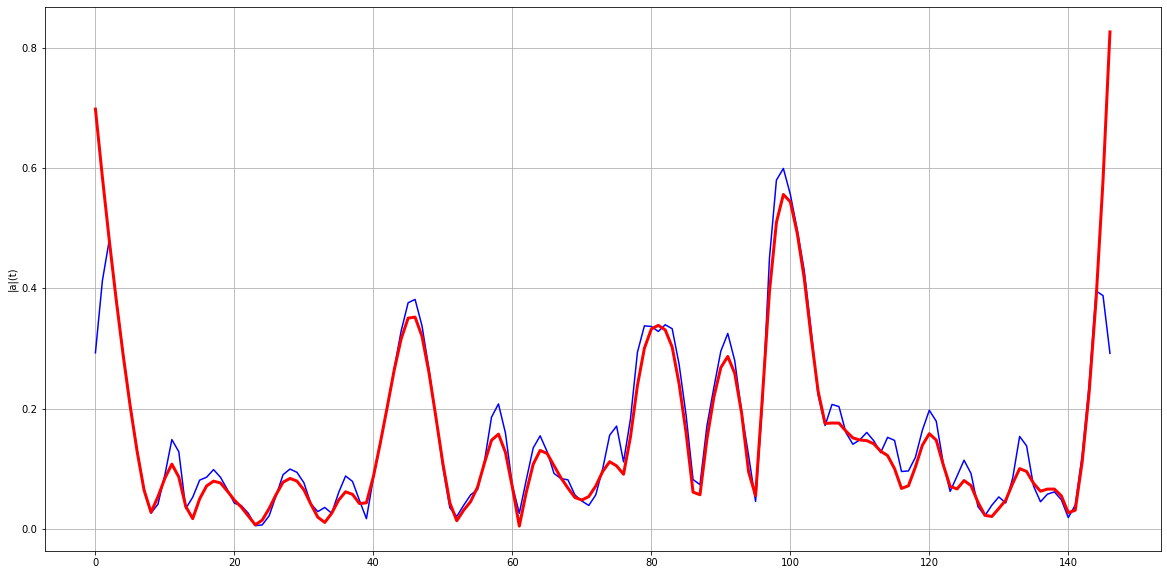

In [30]:
# hogyan alakult a gyorsulás nagysága?
fig=plt.figure(figsize=(20,10))  
ax1=fig.add_subplot(111) 
ax1.plot(t_arr, a_abs_arr, color="blue")
ax1.plot(t_arr, as_abs_arr, color="red", linewidth=3) 
ax1.set_ylabel("|a|(t)")
ax1.grid()

In [31]:
# Hogyan lehet eldönteni, mikor fékezett, mikor gyorsított, mikor kanyarodott a mozgó test?
# Ez önálló feladat. Tipp: gyorsulás- és sebességvektorok irányaival kell játszani...